In [2]:
import os
from glob import glob
import torch
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.notebook import tqdm

plt.rcParams["figure.figsize"] = (8,4)

#### Class Imbalance

In [76]:
from pprint import pprint


dataset = 'gmaps'
PATCH_SIZE = 16
IMG_SIZE = 400
THRESHOLD = 0.25

def dataset_stats(dataset, group=False):
    fnames = sorted(glob(os.path.join(os.environ['CIL_DATA'], dataset, 'groundtruth', '*.png')))

    stats = {} 
    stats[dataset] = dict(pixel_count=0, pixel_total=0, patch_count=0, patch_total=0)
    for fname in tqdm(fnames):

        pixmask = cv2.imread(fname)[:,:,0] // 255
        patchmask = pixmask.reshape((IMG_SIZE // PATCH_SIZE, PATCH_SIZE, IMG_SIZE // PATCH_SIZE, PATCH_SIZE))
        patchmask = np.mean(patchmask, axis=(1,3)) > THRESHOLD

        # dataset stats
        stats[dataset]['pixel_count'] += np.sum(pixmask)
        stats[dataset]['pixel_total'] += np.size(pixmask)
        stats[dataset]['patch_count'] += np.sum(patchmask)
        stats[dataset]['patch_total'] += np.size(patchmask)

        if group: # group stats
            gname = ' '.join(os.path.split(fname)[1].split('_')[0:-1])

            if gname not in stats.keys(): # init new group
                stats[gname] = dict(pixel_count=0, pixel_total=0, patch_count=0, patch_total=0)
            stats[gname]['pixel_count'] += np.sum(pixmask)
            stats[gname]['pixel_total'] += np.size(pixmask)
            stats[gname]['patch_count'] += np.sum(patchmask)
            stats[gname]['patch_total'] += np.size(patchmask)


    # aggregate
    for name in stats.keys():
        stats[name]['pixel_mean'] = stats[name]['pixel_count'] / stats[name]['pixel_total']
        stats[name]['patch_mean'] = stats[name]['patch_count'] / stats[name]['patch_total']

    return stats


stats = dataset_stats('training')
stats.update(dataset_stats('gmaps', group=True))

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [77]:
pprint(stats)

{'boston': {'patch_count': 13745,
            'patch_mean': 0.19992727272727273,
            'patch_total': 68750,
            'pixel_count': 2482538.0,
            'pixel_mean': 0.14105329545454545,
            'pixel_total': 17600000},
 'chicago': {'patch_count': 330393,
             'patch_mean': 0.12998003442340791,
             'patch_total': 2541875,
             'pixel_count': 55606191.0,
             'pixel_mean': 0.08545333015736416,
             'pixel_total': 650720000},
 'gmaps': {'patch_count': 1162190,
           'patch_mean': 0.15495866666666666,
           'patch_total': 7500000,
           'pixel_count': 198198655.0,
           'pixel_mean': 0.10322846614583334,
           'pixel_total': 1920000000},
 'houston': {'patch_count': 191385,
             'patch_mean': 0.17649337175792507,
             'patch_total': 1084375,
             'pixel_count': 33074188.0,
             'pixel_mean': 0.11914332853025937,
             'pixel_total': 277600000},
 'los angeles': {'patch_

Text(0.5, 0.98, 'Amount of road labels')

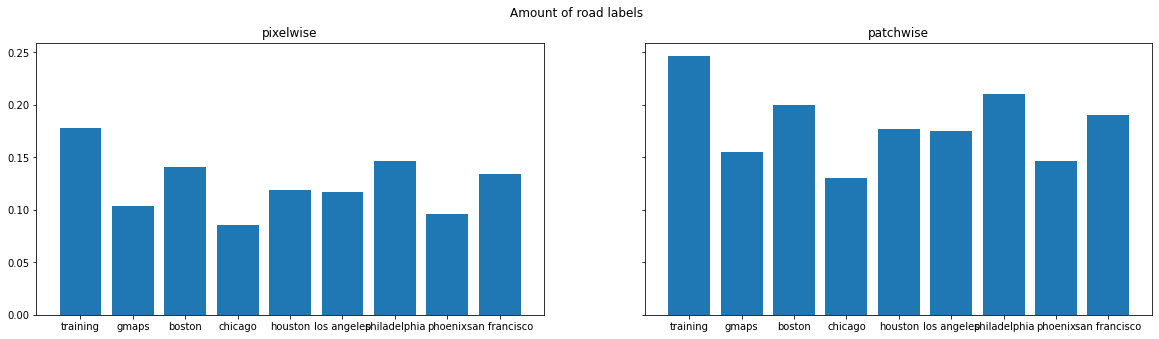

In [78]:
pixel_mean, pixel_mean_lbl = zip(*[(stat['pixel_mean'], name) for name, stat in stats.items()])
patch_mean, patch_mean_lbl = zip(*[(stat['patch_mean'], name) for name, stat in stats.items()])

_, ax = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
ind = range(len(pixel_mean))
ax[0].bar(ind, pixel_mean),
ax[0].set_xticks(ind, pixel_mean_lbl)
ax[0].set_title('pixelwise')

ax[1].bar(ind, patch_mean),
ax[1].set_xticks(ind, patch_mean_lbl)
ax[1].set_title('patchwise')
plt.suptitle('Amount of road labels')

#### Crossentropy Term 

Text(0.5, 1.0, 'CE-term for predictions and target $p_t=1$')

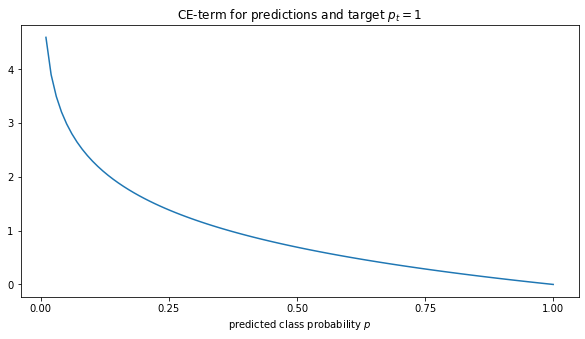

In [79]:
pred = torch.linspace(0, 1, 100)
ce = -torch.log(pred)

plt.plot(pred, ce)
plt.xticks(torch.linspace(0, 1, 5))
plt.xlabel('predicted class probability $p$')
plt.title('CE-term for predictions and target $p_t=1$')

Text(0.5, 1.0, 'CE-term for predictions and targets $p_t$')

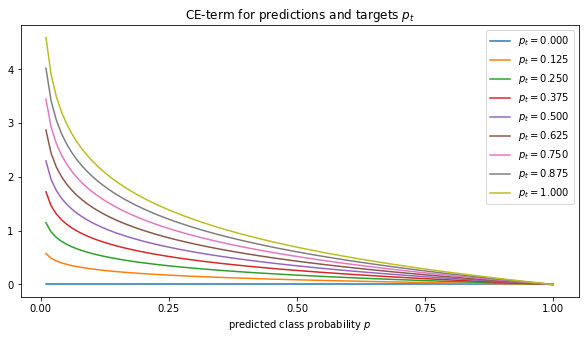

In [80]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)
ce = -target*torch.log(pred)

plt.plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('CE-term for predictions and targets $p_t$')

#### Crossentropy Loss 

Text(0.5, 1.0, 'BCE loss for predictions and targets $p_t$')

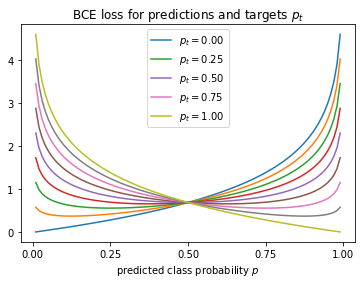

In [6]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)
ce = -(1-target)*torch.log(1-pred) -target*torch.log(pred)

plt.plot(pred, ce, label=[f'$p_t={t.item():.2f}$' if t in [0, 0.25, 0.5, 0.75, 1] else '' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('BCE loss for predictions and targets $p_t$')

Text(0.5, 1.0, 'BBCE loss for predictions and targets $p_t$, $\\nu=0.18$')

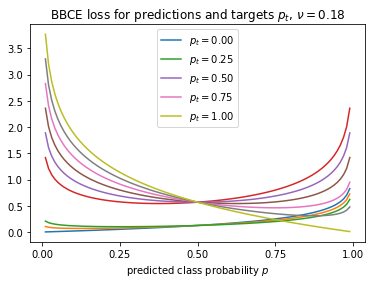

In [15]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

class_freq = 0.18
class_thresh = 0.25
target_class = target > class_thresh

weight = torch.zeros_like(target)
weight[target_class] = 1 - class_freq
weight[~target_class] = class_freq


ce = weight * (-(1-target)*torch.log(1-pred) -target*torch.log(pred))

plt.plot(pred, ce, label=[f'$p_t={t.item():.2f}$' if t in [0, 0.25, 0.5, 0.75, 1] else '' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title(f'BBCE loss for predictions and targets $p_t$, $\\nu={class_freq}$')

#### Focal Loss

Text(0.5, 1.0, 'CE-term for predictions, target $p_t=1$ and parameters $\\gamma$')

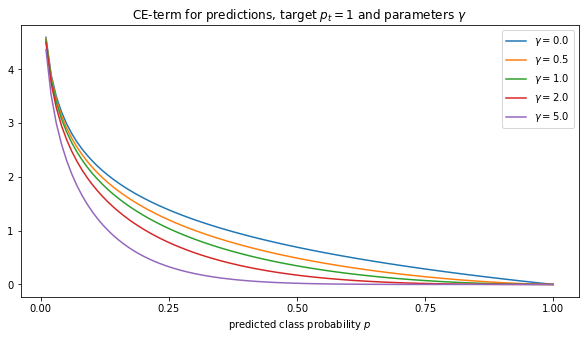

In [83]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
gamma = torch.tensor([0, 0.5, 1, 2, 5]).unsqueeze(0)


ce = - ((1-pred)**gamma) * torch.log(pred)
plt.plot(pred, ce, label=[f'$\gamma={g.item():.1f}$' for g in gamma.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability $p$')
plt.title('CE-term for predictions, target $p_t=1$ and parameters $\gamma$')

Text(0.5, 1.0, 'CE loss for predictions, targets $p_t$ and $\\gamma=2$')

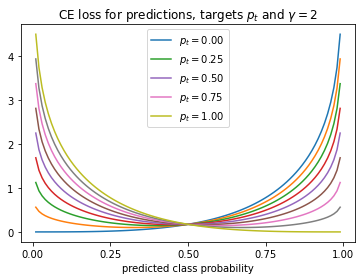

In [16]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

gamma = 2
ce = - ((pred)**gamma) * (1-target)*torch.log(1-pred) -  ((1-pred)**gamma) * target*torch.log(pred)


plt.plot(pred, ce, label=[f'$p_t={t.item():.2f}$' if t in [0, 0.25, 0.5, 0.75, 1] else '' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability')
plt.title(f'CE loss for predictions, targets $p_t$ and $\gamma={gamma}$')

Text(0.5, 1.0, 'Focal loss for predictions, targets $p_t$ and $\\gamma=2$, $\\nu=0.18$')

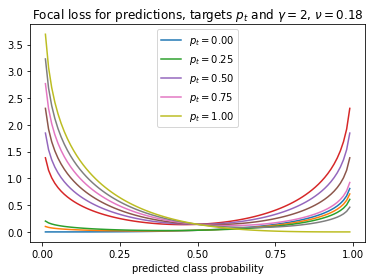

In [22]:
pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

gamma = 2
class_freq = 0.18
class_thresh = 0.25
target_class = target > class_thresh

weight = torch.zeros_like(target)
weight[target_class] = 1 - class_freq
weight[~target_class] = class_freq

ce = weight * (- ((pred)**gamma) * (1-target)*torch.log(1-pred) -  ((1-pred)**gamma) * target*torch.log(pred))


plt.plot(pred, ce, label=[f'$p_t={t.item():.2f}$' if t in [0, 0.25, 0.5, 0.75, 1] else '' for t in target.T])
plt.xticks(torch.linspace(0, 1, 5))
plt.legend()
plt.xlabel('predicted class probability')
plt.title(f'Focal loss for predictions, targets $p_t$ and $\gamma={gamma}$, $\\nu={class_freq}$')

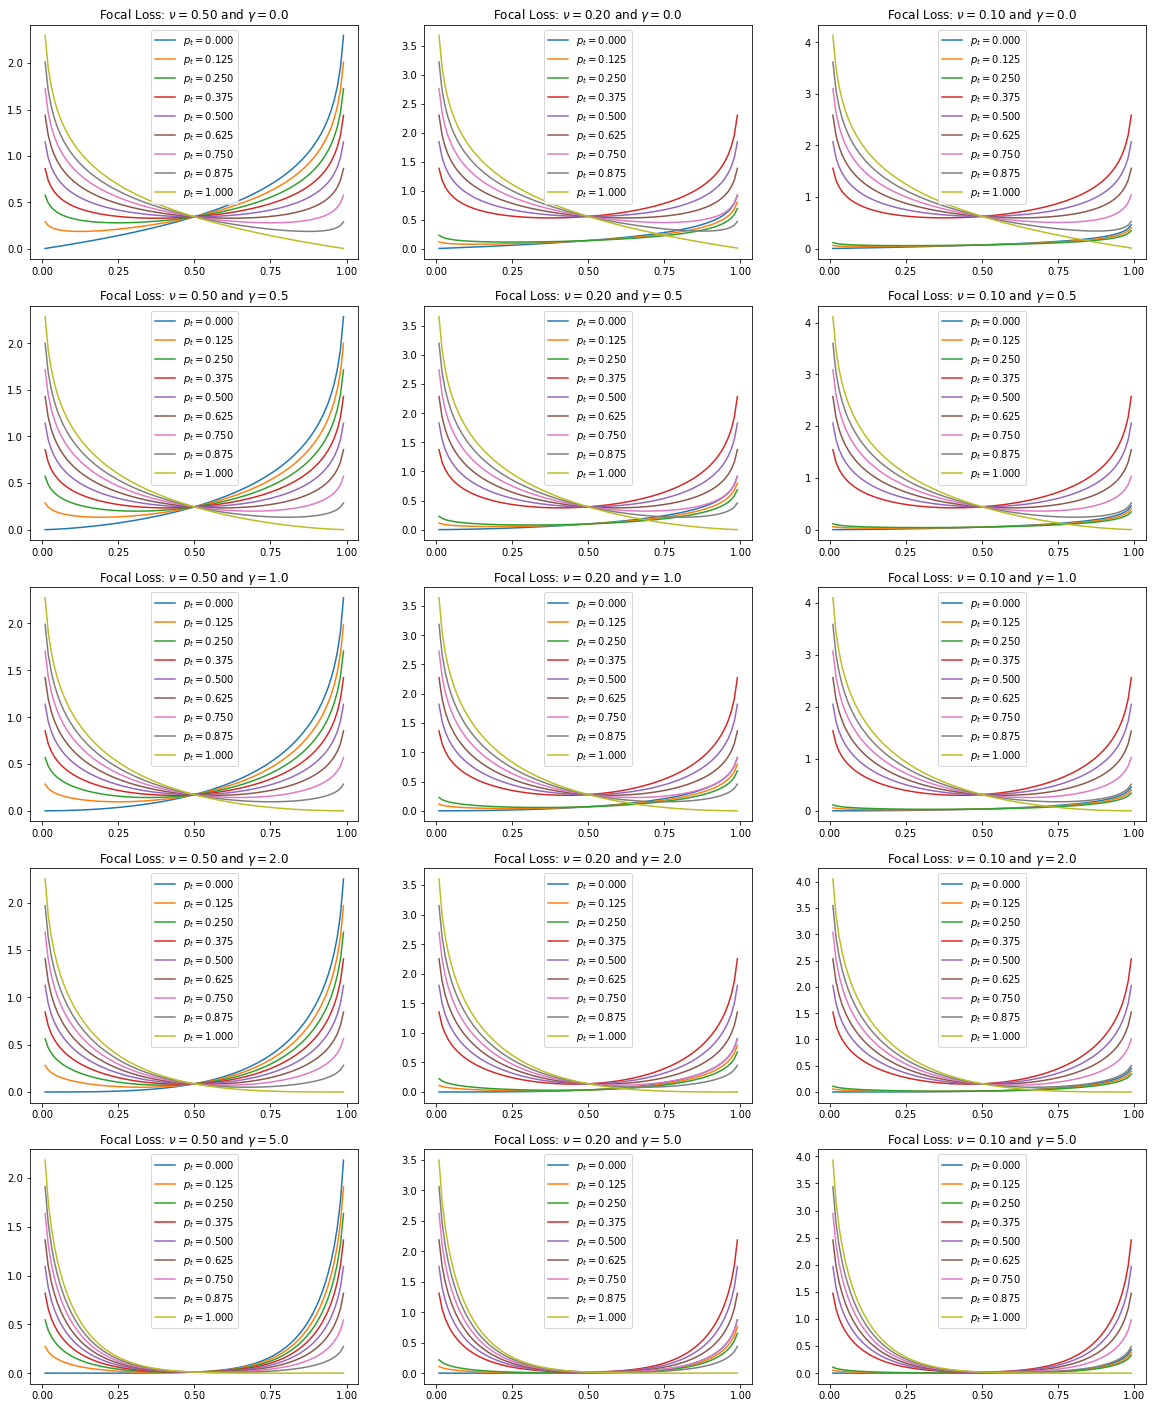

In [19]:

pred = torch.linspace(0, 1, 100).unsqueeze(1)
target = torch.linspace(0, 1, 9).unsqueeze(0)

class_thresh = 0.25
gammas = torch.tensor([0, 0.5, 1, 2, 5])
class_freqs = torch.tensor([0.5, 0.20, 0.10])

_, ax = plt.subplots(len(gammas), len(class_freqs), figsize=(20, 25))
for i, gamma in enumerate(gammas):
    for j, class_freq in enumerate(class_freqs):
        target_class = target > class_thresh

        weight = torch.ones_like(target)
        weight[target_class] = 1 - class_freq
        weight[~target_class] = class_freq

        ce = weight * (- ((pred)**gamma) * (1-target)*torch.log(1-pred) -  ((1-pred)**gamma) * target*torch.log(pred))
        
        ax[i][j].plot(pred, ce, label=[f'$p_t={t.item():.3f}$' for t in target.T])
        ax[i][j].set_xticks(torch.linspace(0, 1, 5))
        ax[i][j].set_title(f'Focal loss: $\\nu={class_freq:.2f}$ and $\gamma={gamma}$')
        ax[i][j].legend()